In [1]:
import openep
from openep._datasets.openep_datasets import DATASET_2

In [2]:
# Set the backend used for plotting
import pyvista
pyvista.set_jupyter_backend('ipygany')

# Load a case
We will load a `.mat` file that was created using OpenEP-MATLAB and then take a look at the data stored in the case

In [7]:
case = openep.load_openep_mat(DATASET_2)

Note, `DATASET_2` is simply a path to a `.mat` file

In [8]:
print(DATASET_2)

/data/KCL/Paul/miniconda3/envs/openep-tutorials/lib/python3.9/site-packages/openep/_datasets/OpenEP-MATLAB/openep_dataset_2.mat


### Look at the surface data


In [12]:
print(case)  # The surface mesh has 14383 nodes, 16942 triangles

openep_dataset_2.mat( nodes: (14383, 3) indices: (16942, 3) fields: ('bipolar_voltage', 'unipolar_voltage', 'local_activation_time', 'impedance', 'force', 'thickness', 'cell_region', 'longitudinal_fibres', 'transverse_fibres', 'pacing_site') )


The nodes and triangle data of the surface mesh are stored in `case.points` and `case.indices` respectively

In [19]:
case.points  # the x, y, z coordinate of each node in the surface mesh

array([[ 46.451, -98.879, 155.286],
       [ 38.777, -94.997, 121.448],
       [ 37.268, -69.189, 141.284],
       ...,
       [-62.585, -77.163, 133.982],
       [-63.766, -76.47 , 119.425],
       [-64.5  , -75.396, 119.241]])

In [21]:
case.indices  # the indices of nodes in each triagle

array([[ 5343,  7474,  7523],
       [ 7976,  4159,  4138],
       [ 7953,  5780, 12295],
       ...,
       [10283, 10270, 14360],
       [10283, 14360, 14361],
       [14380,  6871, 14364]])

Scalar data associated with the mesh are stored in `case.fields`

In [23]:
case.fields

fields: ('bipolar_voltage', 'unipolar_voltage', 'local_activation_time', 'impedance', 'force', 'thickness', 'cell_region', 'longitudinal_fibres', 'transverse_fibres', 'pacing_site')

In [24]:
case.fields.bipolar_voltage

array([    nan, 1.07604, 1.71656, ..., 0.32316, 0.16372, 0.19536])

### Visualising the surface mesh

In [14]:
mesh = case.create_mesh()  # creates a pyvista.PolyData mesh from case.points and case.indices

In [19]:
mesh

PolyData (0x7ff36d10de80)
  N Cells:	16942
  N Points:	14383
  X Bounds:	-7.584e+01, 6.374e+01
  Y Bounds:	-1.300e+02, -3.585e+01
  Z Bounds:	7.937e+01, 1.712e+02
  N Arrays:	2

In [26]:
plotter = openep.draw.draw_map(
    mesh=mesh,
    field=case.fields.bipolar_voltage,
    add_mesh_kws=dict(cmap='Turbo'),
)  # creates a pyvista.Plotter


In [27]:
plotter.show()

AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options={'BrBG':…

In [39]:
mesh.plot()

AppLayout(children=(VBox(children=(HTML(value='<h3>Data</h3>'), Dropdown(description='Colormap:', options={'Br…

### Electrical data
The bipolar electrograms, unipolar electrograms, reference electrograms, and ecgs are all stored in `case.electric`

In [9]:
case.electric  # we see there are 800 mapping points in this case

Electric data for 800 mapping points.

In [10]:
case.electric.bipolar_egm  # this is an Electrogram object, containing information about bipolar egms

Electrograms with 800 mapping points.

In [15]:
dir(case.electric.bipolar_egm)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_egm',
 '_gain',
 '_is_electrical',
 '_names',
 '_points',
 '_voltage',
 'copy',
 'egm',
 'gain',
 'n_points',
 'n_samples',
 'names',
 'points',
 'voltage']

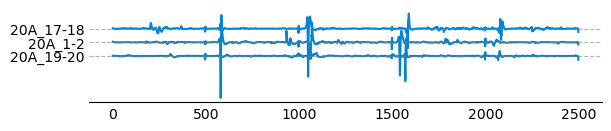

In [53]:
egm_figure, egm_axes = openep.draw.plot_electrograms(
    times=case.electric.times,
    electrograms=case.electric.bipolar_egm.egm[:3],  # plot the first 3 electrograms
    names=case.electric.bipolar_egm.names[:3],  # pass the first 3 electrode names
)  # creates a matplotlib.pyplot.Figure and matplotlib.pyplot.Axes


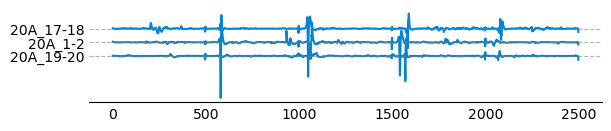

In [54]:
egm_figure

In [52]:
egm_axes

<AxesSubplot:>

### Interpolate electrical data onto the surface mesh
The bipolar voltage we visualised above (`case.fields.bipolar_voltage`) was calculated by CARTO and then exported from the mapping system.

However, it is not known what interpolation method is used by CARTO (or other system vendors) nor the interpolation parameters.

We can use OpenEP to re-interpolate electrical data onto the surface.

In [74]:
bipolar_voltage = openep.case.interpolate_voltage_onto_surface(case=case)

In [72]:
plotter = openep.draw.draw_map(
    mesh=mesh,
    field=case.fields.bipolar_voltage,
    add_mesh_kws=dict(cmap='Turbo'),
    plotter=plotter,
)
plotter.show()


AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options={'BrBG':…

In [76]:
plotter = openep.draw.draw_map(
    mesh=mesh,
    field=bipolar_voltage,
    add_mesh_kws=dict(cmap='Turbo'),
    plotter=plotter,
)
plotter.show()


AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options={'BrBG':…